In [1]:
import zipfile

zip_path = '/content/drive/MyDrive/RHD_v1-1.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install timm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**IMPORT**

In [4]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision import transforms
import timm


In [5]:
image_directory ='/content/RHD_published_v2/training/color'
annotations_file = '/content/RHD_published_v2/training/anno_training.pickle'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 12

**Example of an image with superimposed keypoints**




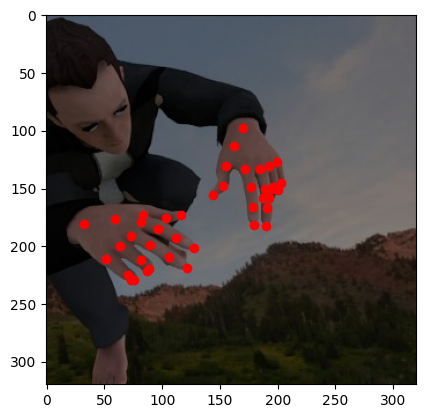

In [6]:


with open(annotations_file, 'rb') as f:
    data_pickle = pickle.load(f)

keypoints_pickle = data_pickle

image_id = 19

image_file = sorted(os.listdir(image_directory))[image_id]
image_path = os.path.join(image_directory, image_file)
image = plt.imread(image_path)

# Получение соответствующих ключевых точек для данного изображения
keypoints = keypoints_pickle[image_id]['uv_vis']

plt.imshow(image)
plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='o')
plt.show()

**Let's make a transformation**

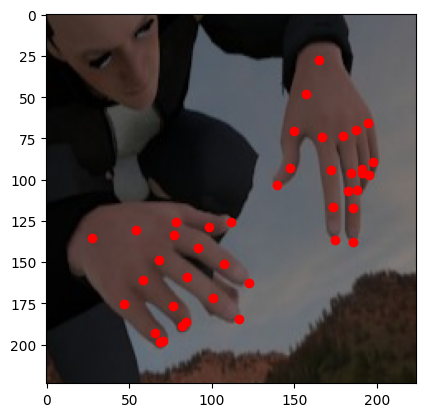

In [7]:
output_size = (224, 224)

# Load the image and keypoints
image_id = 19
image_file = sorted(os.listdir(image_directory))[image_id]
image_path = os.path.join(image_directory, image_file)
image = Image.open(image_path)
keypoints = keypoints_pickle[image_id]['uv_vis']

# Calculate the bounding box of the keypoints
min_x = np.min(keypoints[:, 0])
max_x = np.max(keypoints[:, 0])
min_y = np.min(keypoints[:, 1])
max_y = np.max(keypoints[:, 1])

# Calculate the center of the bounding box
center_x = (min_x + max_x) / 2
center_y = (min_y + max_y) / 2

# Calculate the width and height of the bounding box
width = max_x - min_x
height = max_y - min_y

# Calculate the scale factor to fit the bounding box into the output size
scale_factor = max(width, height) / max(output_size)

# Calculate the target width and height after scaling
target_width = int(width / scale_factor)
target_height = int(height / scale_factor)

# Calculate the top-left corner coordinates of the cropped region
top = int(center_y - target_height / 2)
left = int(center_x - target_width / 2)

# Crop the image
cropped_image = TF.crop(image, top, left, target_height, target_width)

# Resize the cropped image to the desired output size
resized_image = TF.resize(cropped_image, output_size)

# Adjust keypoints coordinates based on the cropping parameters
keypoints[:, 0] = (keypoints[:, 0] - left) * (output_size[0] / target_width)
keypoints[:, 1] = (keypoints[:, 1] - top) * (output_size[1] / target_height)

# Visualize the cropped and resized image with keypoints
plt.imshow(resized_image)
plt.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='o')
plt.show()



In [8]:


class CustomDataset(Dataset):
    def __init__(self, annotations_file, image_directory, output_size):
        with open(annotations_file, 'rb') as f:
            data_pickle = pickle.load(f)
        self.keypoints_pickle = data_pickle
        self.image_directory = image_directory
        self.output_size = output_size
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
       return len(self.keypoints_pickle)

    def __getitem__(self, idx):
        keypoints = self.keypoints_pickle[idx]['uv_vis']
        keypoints = np.array(keypoints)
        keypoints = keypoints[:, :2]  # Extract only x and y coordinates
        keypoints = torch.Tensor(keypoints)

        image_file = sorted(os.listdir(self.image_directory))[idx]
        image_path = os.path.join(self.image_directory, image_file)
        image = Image.open(image_path)

        # Crop and resize the image
        cropped_image, keypoints = self.crop_and_resize(image, keypoints)

        # Apply transformations
        image_tensor = self.transform(cropped_image)

        return image_tensor, keypoints

    def crop_and_resize(self, image, keypoints):
        if torch.is_tensor(keypoints):
          keypoints = keypoints.numpy()
    # Calculate bounding box and crop parameters
        min_x = np.min(keypoints[:, 0])
        max_x = np.max(keypoints[:, 0])
        min_y = np.min(keypoints[:, 1])
        max_y = np.max(keypoints[:, 1])
        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2
        width = max_x - min_x
        height = max_y - min_y
        scale_factor = max(width, height) / max(self.output_size)
        target_width = int(width / scale_factor)
        target_height = int(height / scale_factor)
        top = int(center_y - target_height / 2)
        left = int(center_x - target_width / 2)

    # Crop the image
        cropped_image = image.crop((left, top, left + target_width, top + target_height))

    # Resize the cropped image
        resized_image = cropped_image.resize(self.output_size)

    # Adjust keypoints coordinates based on the cropping and resizing

        if target_width != 0:
            keypoints[:, 0] = (keypoints[:, 0] - left) * (self.output_size[0] / target_width)
        if target_height != 0:
            keypoints[:, 1] = (keypoints[:, 1] - top) * (self.output_size[1] / target_height)


        return resized_image, keypoints






In [9]:
# Create the dataset
dataset = CustomDataset(annotations_file, image_directory, output_size)

# Split into train and validation datasets
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)


In [10]:
def oks(y_true, y_pred, visibility):
    KAPPA = np.array([1] * len(y_true))
    SCALE = 1.0

    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

**uploading the model**

In [11]:
class ModifiedModel(nn.Module):
    def __init__(self, original_model, num_keypoints):
        super(ModifiedModel, self).__init__()
        self.features = original_model.features
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(original_model.classifier[1].in_features, num_keypoints * 2),
            nn.Sigmoid()
        )
        self.num_keypoints = num_keypoints

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = x.view(x.size(0), self.num_keypoints, 2)
        return x


original_model = models.mobilenet_v2(pretrained=True)
num_keypoints = 42
model = ModifiedModel(original_model, num_keypoints)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
lr = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 15

**model training**

In [ ]:
num_epochs = 15

model.train()
model.to(device)  # Move the model to the GPU device

for epoch in range(num_epochs):
    train_loss = []
    train_predictions = []
    train_targets = []

    for batch, targets in tqdm(train_loader, desc=f"Epoch: {epoch+1}"):
        optimizer.zero_grad()

        batch = batch.to(device)
        targets = targets.to(device)

        predictions = model(batch)

        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        predictions = predictions.cpu().detach().numpy().reshape(-1, num_keypoints * 2)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, num_keypoints * 2)
        train_targets.extend(targets)

    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)

    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets[:, :2], train_predictions[:, :2], train_targets[:, 2]))

    model.eval()

    val_predictions = []
    val_targets = []

    for batch, targets in tqdm(val_loader, desc=f"Epoch: {epoch+1}"):
        with torch.no_grad():
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)

            predictions = predictions.cpu().numpy().reshape(-1, num_keypoints * 2)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, num_keypoints * 2)
            val_targets.extend(targets)

    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)

    print('Val OKS:', oks(val_targets[:, :2], val_predictions[:, :2], val_targets[:, 2]))



Epoch: 1: 100%|██████████| 2751/2751 [27:43<00:00,  1.65it/s]


Training loss: 239866825000.56897
Train OKS: 1.819627980734928e-06


Epoch: 1: 100%|██████████| 688/688 [06:27<00:00,  1.77it/s]


Val OKS: 6.803678100507585e-06


Epoch: 2: 100%|██████████| 2751/2751 [27:51<00:00,  1.65it/s]


Training loss: 239866810105.8247
Train OKS: 3.6709698470071914e-06


Epoch: 2: 100%|██████████| 688/688 [06:30<00:00,  1.76it/s]


Val OKS: 7.607491943843961e-07


Epoch: 3:  99%|█████████▉| 2732/2751 [27:20<00:14,  1.33it/s]